<a href="https://colab.research.google.com/github/Ali-Noghabi/linear-SAT-solver/blob/main/logic_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get install graphviz libgraphviz-dev pkg-config
!pip install pygraphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6).
The following packages were automatically installed and are no longer required:
  libbz2-dev libpkgconf3 libreadline-dev
Use 'apt autoremove' to remove them.
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common libgvc6-plugins-gtk
  librsvg2-common libxdot4
Suggested packages:
  gvfs
The following packages will be REMOVED:
  pkgconf r-base-dev
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4 pkg-config
0 upgraded, 10 newly installed, 2 to remove and 45 not upgraded.
Need to get 2,481 kB of archives.
After this operation, 7,683 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 pkg-config amd64 0.29

In [2]:
import re
import uuid
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
from itertools import product

In [3]:
class Node:
    def __init__(self, value, children=None):
        self.value = value
        self.children = children if children else []
        self.id = None  # Unique identifier for each node
        self.isShared = False

    def set_id(self, node_id):
        if self.id is None:
            self.id = node_id

    def DAG(self, level=0, prefix=""):
        # Include the node ID in the output
        ret = "\t" * level + prefix + f"Node {self.id}: {self.value}"
        if(self.isShared == True):
          ret += " (shared)\n"
        else:
          ret += "\n"
        for i, child in enumerate(self.children):
            ret += child.DAG(level + 1, "├── " if i < len(self.children) - 1 else "└── ")
        return ret
    def tree(self, level=0, prefix=""):
        ret = "\t" * level + prefix + str(self.value) + "\n"
        for i, child in enumerate(self.children):
            ret += child.tree(level + 1, "├── " if i < len(self.children) - 1 else "└── ")
        return ret


In [4]:
def translate(expr):
    # Helper function to handle negation and implication
    def replace_implication(match):
        left = match.group(1)
        right = match.group(2)
        # Recursive translation of each side of the implication
        left_translated = translate(left.strip())
        right_translated = translate(right.strip())
        return f'(¬{left_translated} ∨ {right_translated})'

    # Remove all spaces to simplify parsing
    expr = re.sub(r'\s+', '', expr)

    # Handle nested expressions first by recursively translating innermost parentheses
    while '(' in expr:
        expr = re.sub(r'\(([^()]+)\)', lambda m: translate(m.group(1)), expr)

    # Translate implications, handling right to left to manage nested implications
    while '→' in expr:
        expr = re.sub(r'([^()→]+)→([^()→]+)', replace_implication, expr)

    # Apply De Morgan's laws to disjunctions after handling implications
    expr = re.sub(r'([^()∨]+)∨([^()∨]+)', lambda m: f'¬(¬{translate(m.group(1))} ∧ ¬{translate(m.group(2))})', expr)

    # Remove double negations as the last step after all other transformations
    while '¬¬' in expr:
        expr = re.sub(r'¬¬', '', expr)

    return expr

# Example usage
print("Translated Formula:", translate("p ∧ ¬(q ∨ ¬p)"))
print("Translated Formula:", translate("p ∧ ¬(q ∨ ¬p) ∧ (p → q)"))
print("Translated Formula:", translate("p → (q → p)"))
print("Translated Formula:", translate("(¬p → q) → (p ∨ q)"))


Translated Formula: p∧¬q∧p
Translated Formula: p∧¬q∧p∧¬p∧¬q
Translated Formula: (¬(p ∧ q∧¬p))
Translated Formula: (¬(p∧¬q ∧ ¬p∧¬q))


∧
	├── p
	└── ∧
		├── ¬
			└── q
		└── p



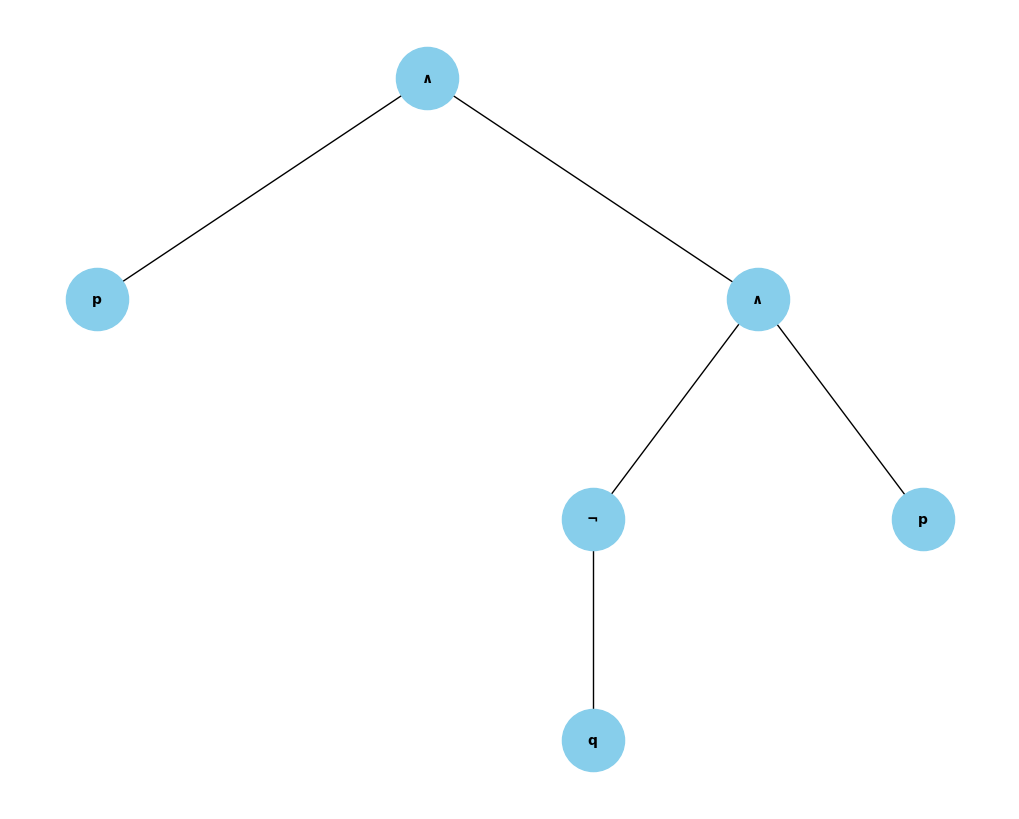

In [5]:
def parse_formula(expr):
    def parse(expr):
        expr = expr.strip()
        if expr.startswith('(') and expr.endswith(')'):
            expr = expr[1:-1].strip()
        operator_pos = find_top_level_operator(expr)
        if operator_pos is not None:
            operator = expr[operator_pos]
            left = expr[:operator_pos]
            right = expr[operator_pos + 1:]
            return Node(operator, [parse(left), parse(right)])
        elif expr.startswith('¬'):
            return Node('¬', [parse(expr[1:].strip())])
        else:
            return Node(expr)

    def find_top_level_operator(expr):
        depth = 0
        for i, char in enumerate(expr):
            if char == '(':
                depth += 1
            elif char == ')':
                depth -= 1
            elif (char == '∧' or char == '∨') and depth == 0:
                return i
        return None

    expr = re.sub(r'\s+', '', expr)
    return parse(expr)

def draw_tree(root):
    def add_edges(node, graph, parent=None, parent_id=None):
        node_id = uuid.uuid4()  # Generate a unique identifier for each node
        if parent is not None:
            graph.add_edge(parent_id, node_id)  # Use the unique identifier instead of node value
        graph.add_node(node_id, label=node.value)  # Use the unique identifier and store the value as a label
        for child in node.children:
            add_edges(child, graph, node, node_id)  # Recursive call with unique id

    G = nx.DiGraph()
    add_edges(root, G)
    pos = hierarchy_pos(G)  # Assuming hierarchy_pos can handle this structure
    plt.figure(figsize=(10, 8))
    labels = {n: G.nodes[n]['label'] for n in G.nodes}  # Extract labels for drawing
    nx.draw(G, pos, labels=labels, with_labels=True, arrows=False, node_size=2000, node_color='skyblue', font_size=10, font_weight='bold')
    plt.show()

def hierarchy_pos(G, root=None, width=1., vert_gap=0.2, vert_loc=0, xcenter=0.5):
    """A function to position nodes to look like a hierarchical tree"""
    if root is None:
        root = next(iter(nx.topological_sort(G)))  # Find the root node
    pos = {root: (xcenter, vert_loc)}
    def _hierarchy_pos(G, root, width=1., vert_gap=0.2, vert_loc=0, xcenter=0.5, pos=None):
        children = list(G.successors(root))
        if children:
            dx = width / len(children)
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos[child] = (nextx, vert_loc - vert_gap)
                _hierarchy_pos(G, child, width=dx, vert_gap=vert_gap, vert_loc=vert_loc - vert_gap, xcenter=nextx, pos=pos)
        return pos
    return _hierarchy_pos(G, root, width=width, vert_gap=vert_gap, vert_loc=vert_loc, xcenter=xcenter, pos=pos)


# Example usage
expr = "p ∧ ¬(q ∨ ¬p)"
translated_expr = translate(expr)
root = parse_formula(translated_expr)
print(root.tree())
draw_tree(root)


Node 1: ¬
	└── Node 2: ∧
		├── Node 3: φ (shared)
		└── Node 4: ∧
			├── Node 5: ψ
			└── Node 6: ¬
				└── Node 3: φ (shared)



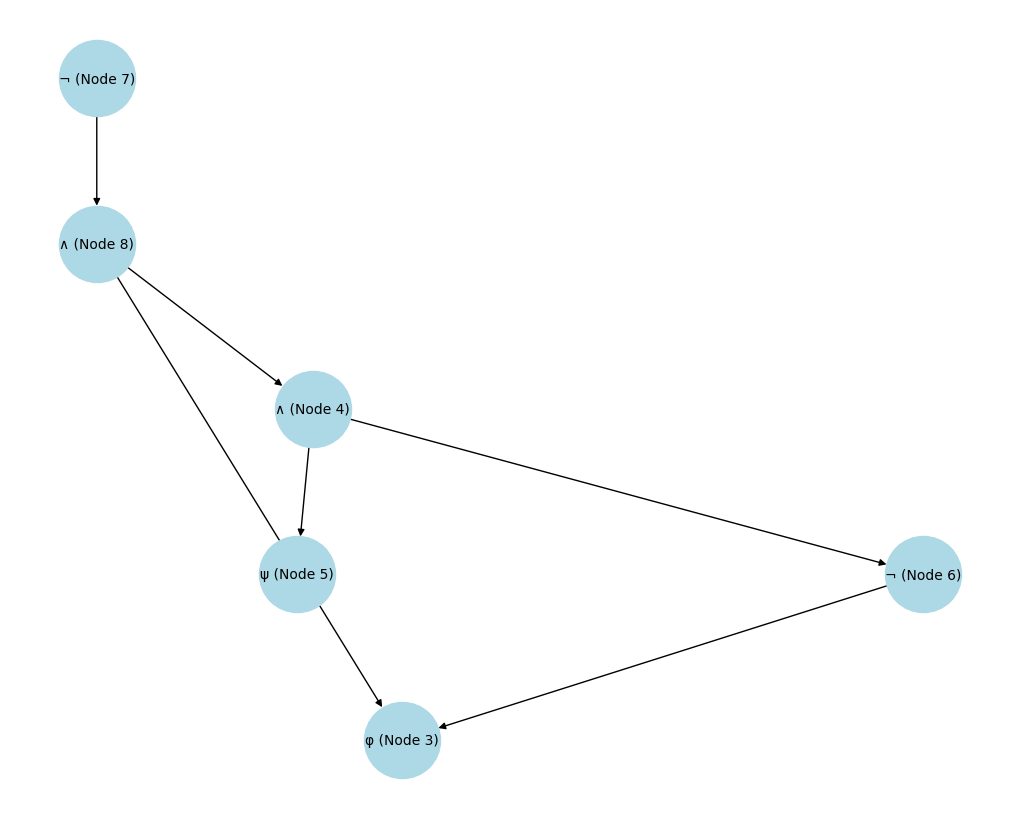

In [6]:
node_counter = 1
node_dict = {}

def parse_formula(expr):
    global node_counter, node_dict
    def parse(expr):
        expr = expr.strip()
        if expr in node_dict:
            node_dict[expr].isShared = True
            return node_dict[expr]  # Reuse node if already parsed

        if expr.startswith('(') and expr.endswith(')'):
            expr = expr[1:-1].strip()

        operator_pos = find_top_level_operator(expr)
        if operator_pos is not None:
            operator = expr[operator_pos]
            left = expr[:operator_pos]
            right = expr[operator_pos + 1:]
            node = Node(operator, [parse(left), parse(right)])
        elif expr.startswith('¬'):
            node = Node('¬', [parse(expr[1:].strip())])
        else:
            node = Node(expr)

        node_dict[expr] = node
        return node

    def assign_ids(node):
        global node_counter
        if node.id is None:
            node.set_id(node_counter)
            node_counter += 1
        for child in node.children:
            assign_ids(child)

    def find_top_level_operator(expr):
        depth = 0
        for i, char in enumerate(expr):
            if char == '(':
                depth += 1
            elif char == ')':
                depth -= 1
            elif (char == '∧' or char == '∨') and depth == 0:
                return i
        return None

    root_node = parse(re.sub(r'\s+', '', expr))
    assign_ids(root_node)
    return root_node

# Example usage
expr = "φ → (ψ → φ)" # L1
root = parse_formula(translate(expr))
print(root.DAG())

def draw_dag(root):
    def add_edges(node, graph, ids):
        if node.id not in ids:
            graph.add_node(node.id, label=f"{node.value} (Node {node.id})")
            ids.add(node.id)
        for child in node.children:
            graph.add_edge(node.id, child.id)
            add_edges(child, graph, ids)

    G = nx.DiGraph()
    ids = set()  # Initialize the set of node IDs
    add_edges(root, G, ids)  # Pass the set to the function
    pos = nx.nx_agraph.graphviz_layout(G, prog='dot')
    plt.figure(figsize=(10, 8))
    labels = {n: G.nodes[n]['label'] for n in G.nodes}
    nx.draw(G, pos, labels=labels, with_labels=True, arrows=True, node_size=3000, node_color='lightblue', font_size=10)
    plt.show()

# Example usage
expr = "φ → (ψ → φ)" # L1
root = parse_formula(translate(expr))
print(root)
draw_dag(root)

In [7]:
def evaluate_formula(node, valuation):
    """ Evaluate the formula based on the current valuation of variables """
    if node.value in valuation:
        return valuation[node.value]
    elif node.value == '¬':
        return not evaluate_formula(node.children[0], valuation)
    elif node.value == '∧':
        return evaluate_formula(node.children[0], valuation) and evaluate_formula(node.children[1], valuation)
    elif node.value == '∨':
        return evaluate_formula(node.children[0], valuation) or evaluate_formula(node.children[1], valuation)
    else:
        raise ValueError("Unsupported operator")

def find_variables(node, vars_set=None):
    """ Find all unique variables in the formula """
    if vars_set is None:
        vars_set = set()
    if node.value in ['∧', '∨', '¬']:
        for child in node.children:
            find_variables(child, vars_set)
    else:
        vars_set.add(node.value)
    return vars_set

def check_satisfiability(root):
    variables = list(find_variables(root))
    all_valuations = list(product([True, False], repeat=len(variables)))
    satisfying_valuations = []
    for valuation in all_valuations:
        val_dict = dict(zip(variables, valuation))
        if evaluate_formula(root, val_dict):
            satisfying_valuations.append(val_dict)
    return satisfying_valuations

def check_tautology(root):
    variables = list(find_variables(root))
    all_valuations = list(product([True, False], repeat=len(variables)))
    for valuation in all_valuations:
        val_dict = dict(zip(variables, valuation))
        if not evaluate_formula(root, val_dict):
            return False
    return True

Translated Formula: p∧¬q∧p
Tree Representation:
∧
	├── p
	└── ∧
		├── ¬
			└── q
		└── p



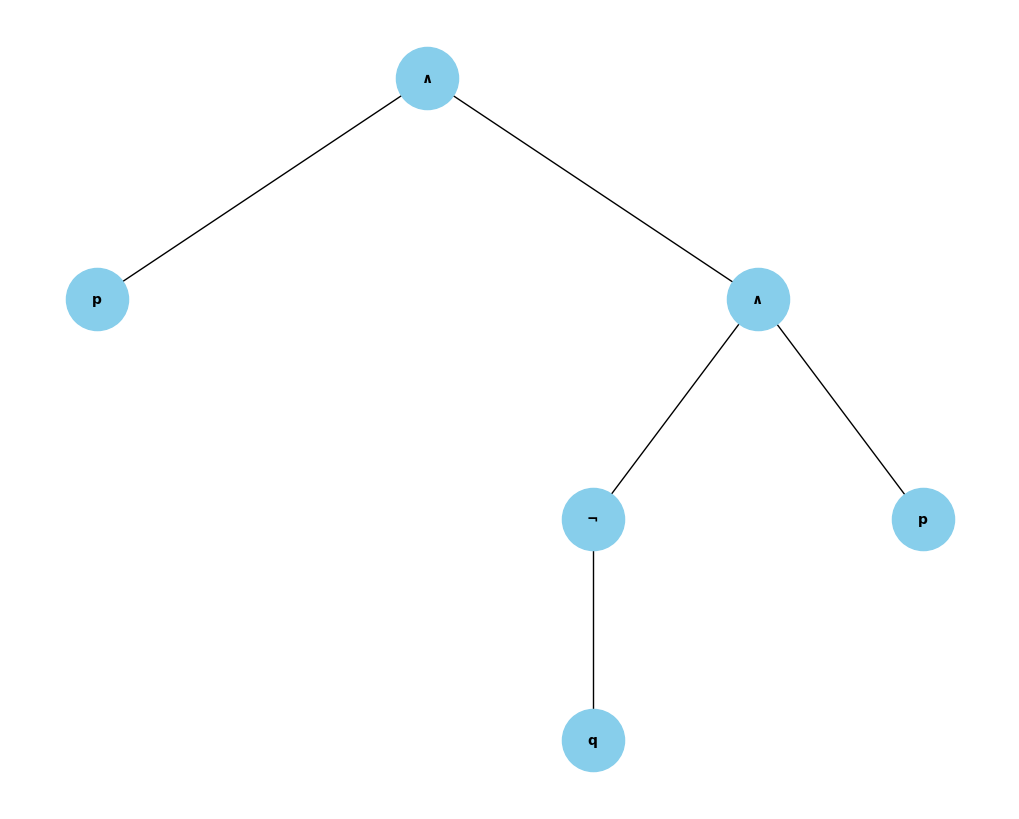

Satisfying Valuations: [{'q': False, 'p': True}]
Is the formula a tautology? False


In [9]:
# Example usage
expr = "p ∧ ¬(q ∨ ¬p)"
# expr = "p ∧ ¬(q ∨ ¬p) ∧ (p → q)"
translated_expr = translate(expr)
print("Translated Formula:", translated_expr)
root = parse_formula(translated_expr)
print("Tree Representation:")
print(root.tree())
draw_tree(root)

# Checking satisfiability and tautology
satisfying_valuations = check_satisfiability(root)
is_tautology = check_tautology(root)

print("Satisfying Valuations:", satisfying_valuations)
print("Is the formula a tautology?", is_tautology)

Translated Formula: (¬(φ ∧ ψ∧¬φ))
Tree Representation:
¬
	└── ∧
		├── φ
		└── ∧
			├── ψ
			└── ¬
				└── φ



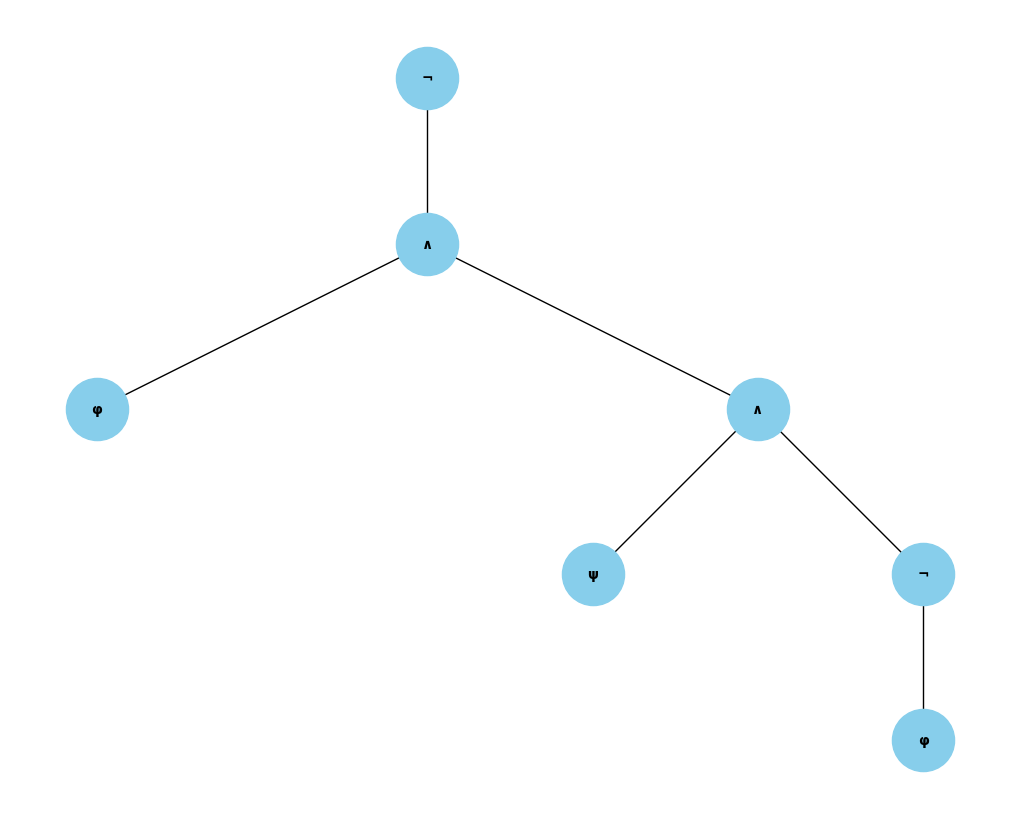

Satisfying Valuations: [{'φ': True, 'ψ': True}, {'φ': True, 'ψ': False}, {'φ': False, 'ψ': True}, {'φ': False, 'ψ': False}]
Is the formula a tautology? True


In [10]:
expr = "φ → (ψ → φ)" # L1
# expr = "(φ → (ψ → θ)) → ((φ → ψ) → (φ → θ))" # L2
# expr = "(¬φ → ¬ψ) → (ψ → φ)" # L3
# expr = "(φ ∧ ψ) → ¬(φ → ¬ψ)" # L4
# expr = "¬(φ → ψ) → (φ ∧ ¬ψ)" # L5
# expr = "(φ ∨ ψ) → (¬φ → ψ)" # L6
# expr = "(¬φ → ψ) → (φ ∨ ψ)" # L7
translated_expr = translate(expr)
print("Translated Formula:", translated_expr)
root = parse_formula(translated_expr)
print("Tree Representation:")
print(root.tree())
draw_tree(root)

# Checking satisfiability and tautology
satisfying_valuations = check_satisfiability(root)
is_tautology = check_tautology(root)

print("Satisfying Valuations:", satisfying_valuations)
print("Is the formula a tautology?", is_tautology)